In [ ]:
import pandas as pd
from tqdm import tqdm

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
# Specifica il nome del dataset path
dataset_path = "/content/drive/MyDrive/Benchmarking LLM/TASK - MULTIMODAL/LLM"

In [ ]:
import json
import pandas as pd
import glob  # Per leggere più file
import re  # Per estrarre la lingua dal nome del file

# 1. Caricare tutti i file JSON presenti nella cartella
file_list = glob.glob("/content/drive/MyDrive/Benchmarking LLM/TASK - MULTIMODAL/LLM/MIR_Multimodal_Dataset_*.json")

In [ ]:
file_list

In [ ]:
import json
import pandas as pd
from collections import defaultdict
import glob
import re
from tqdm import tqdm  # Per la barra di avanzamento

# Trova tutti i file JSON
json_files = glob.glob("/content/drive/MyDrive/Benchmarking LLM/TASK - MULTIMODAL/LLM/MIR_Multimodal_Dataset_*.json")

# Dizionario per raccogliere i dati
all_data = defaultdict(lambda: {
    'Question': None,
    'Category': None,
    'Language': None,
    'Image URL': None,  # Campo aggiornato
    'Models': {}
})

# Elaborazione dei file JSON
for file_path in tqdm(json_files, desc="Processing JSON files"):
    # Estrarre la lingua dal nome del file
    match = re.search(r"MIR_Multimodal_Dataset_(English|Spanish|Italian)", file_path)
    language = match.group(1) if match else "Unknown"

    with open(file_path, "r", encoding="utf-8") as json_file:
        data = json.load(json_file)

        # Iterazione sui dati
        for entry in data:
            try:
                question = entry.get("Question")
                category = entry.get("Category")
                model = entry.get("Model")  # Nome del modello
                is_correct = entry.get("Is Correct", False)
                image_url = entry.get("Image URL")  # Campo aggiornato

                # Crea una chiave unica basata su Question e Category
                key = (question, category)

                # Aggiungi i dati al dizionario
                all_data[key]['Question'] = question
                all_data[key]['Category'] = category
                all_data[key]['Language'] = language  # Aggiunta della lingua
                all_data[key]['Image URL'] = image_url  # Campo aggiornato
                all_data[key]['Models'][model] = 1 if is_correct else 0

            except Exception as e:
                continue  # Ignora eventuali errori nel parsing

# Creazione della lista finale
final_data = []

for key, value in all_data.items():
    row = {
        'Question': value['Question'],
        'Category': value['Category'],
        'Language': value['Language'],
        'Image URL': value['Image URL'],  # Campo aggiornato
    }

    # Aggiungi le colonne per ogni modello
    for model, is_correct in value['Models'].items():
        row[model] = is_correct

    final_data.append(row)

# Creazione del DataFrame finale
df = pd.DataFrame(final_data)


Processing JSON files: 100%|██████████| 24/24 [00:14<00:00,  1.63it/s]


Casi in cui Llava ha risposto bene (ne prendo tre) 194, 197 e 198

In [ ]:
df[df['Language'] == 'English']

In [ ]:
df["Error_count"] = df.iloc[:, 4:].apply(lambda row: (row == 0).sum(), axis=1)
df_sorted = df.sort_values("Error_count", ascending=False)
# Filtrare solo le domande con più di 6 errori
df_filtered = df_sorted[df_sorted["Error_count"] > 6]

# Contare le occorrenze per categoria
category_counts = df_filtered["Category"].value_counts()

# Contare le occorrenze per lingua
language_counts = df_filtered["Language"].value_counts()

# Visualizzare i risultati
print("Distribuzione delle categorie con più errori:")
print(category_counts)
print("\nDistribuzione delle lingue con più errori:")
print(language_counts)

# Calcolare il totale delle domande con più di 6 errori
total_filtered = df_filtered.shape[0]

# Calcolare i tassi in percentuale per categoria e lingua
category_percentages = (category_counts / total_filtered) * 100
language_percentages = (language_counts / total_filtered) * 100

# Visualizzare i risultati in percentuale
print("Distribuzione delle categorie con più errori (in percentuale):")
print(category_percentages)
print("\nDistribuzione delle lingue con più errori (in percentuale):")
print(language_percentages)


Distribuzione delle categorie con più errori:
Category
Anatomía Patológica                 10
Thoracic pneumology and surgery     10
Pneumologia toracica e chirurgia     9
Cardiología y Cirugía Cardiaca       9
Traumatología                        8
Pathological anatomy                 8
Cardiologia e cardiochirurgia        8
Digestive and General Surgery        8
Cardiology and cardiac surgery       8
Neumología y Cirugía Torácica        8
Anatomia patologica                  8
Chirurgia digestiva e generale       7
Traumatology                         7
Digestivo y Cirugía General          7
Hematología                          6
Ematologia                           6
Infectious and microbiology          5
Traumatologia                        5
Hematology                           5
Reumatologia                         5
Chirurgia endocrina e endocrina      4
Reumatología                         4
Infecciosas y Microbiología          4
Oftalmologia                         4
Anatomy  

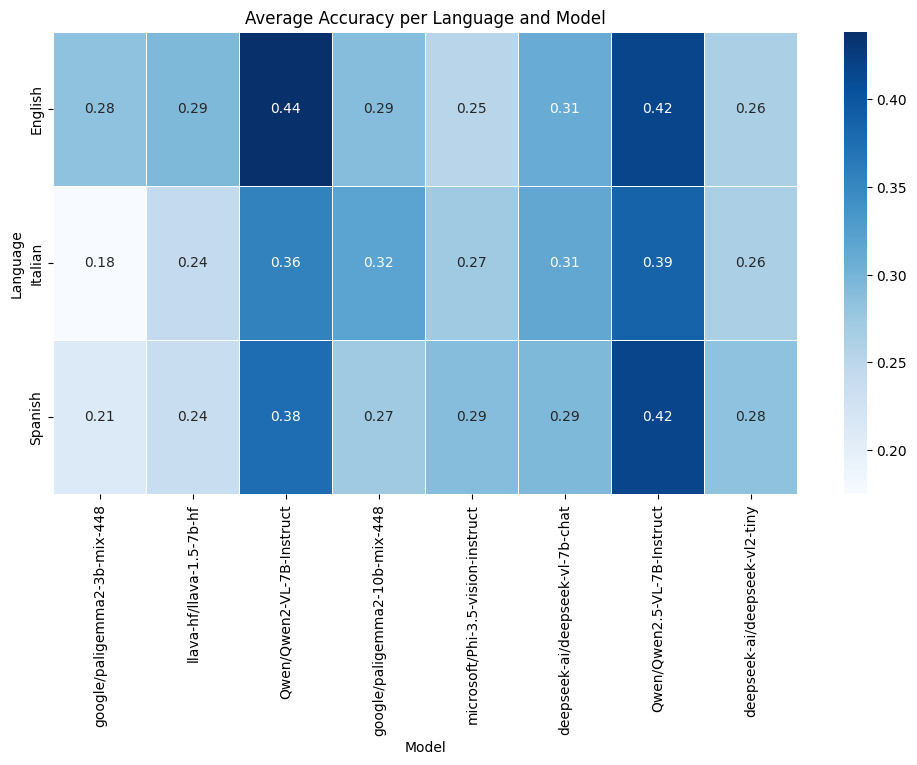

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Seleziona solo le colonne dei modelli
model_columns = df.columns[4:]

# Calcolare la media delle risposte corrette per ciascuna lingua
language_accuracy = df.groupby("Language")[model_columns].mean()

# Visualizzare la media di accuratezza per lingua
plt.figure(figsize=(12,6))
sns.heatmap(language_accuracy, annot=True, cmap="Blues", fmt=".2f", linewidths=0.5)
plt.title("Average Accuracy per Language and Model")
plt.xlabel("Model")
plt.ylabel("Language")
plt.show()

<ipython-input-9-896adca8259d>:29: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  colors = plt.cm.get_cmap('tab10', len(models))  # Colori distinti per ogni modello


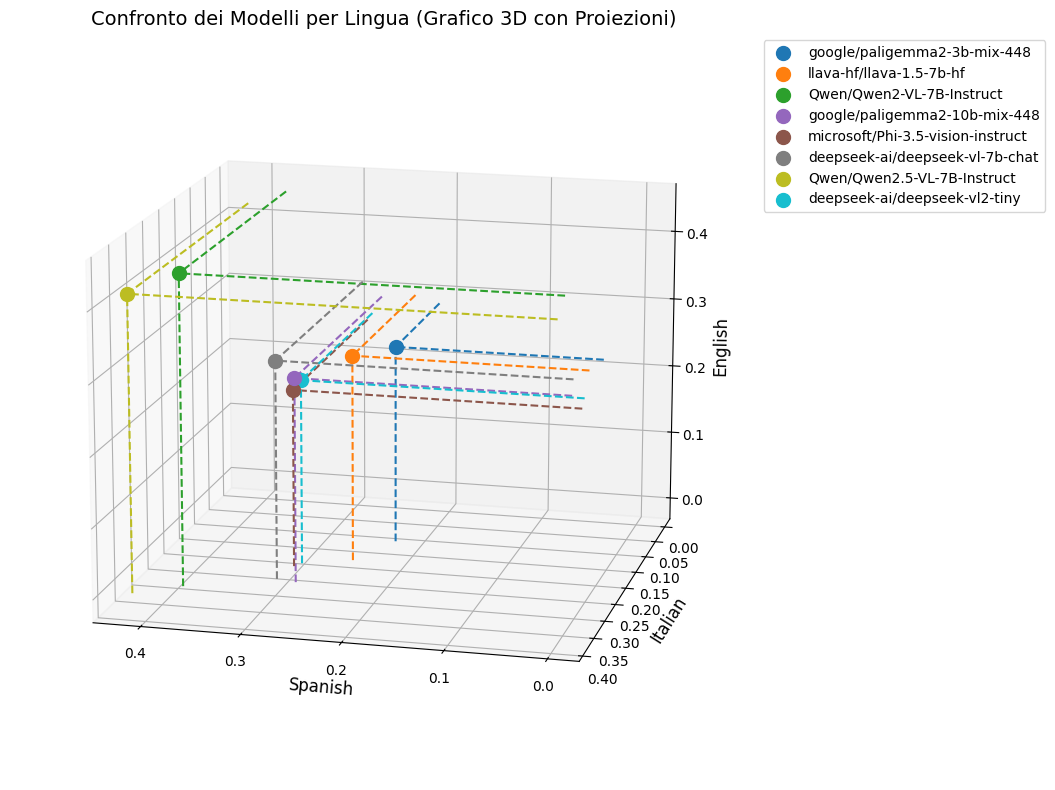

In [ ]:
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import numpy as np

# Calcoliamo i punteggi medi per ogni lingua e modello (assumiamo che 'df' sia il tuo dataframe)
# Supponiamo che 'model_columns' contenga i nomi delle colonne relative ai modelli.

# Creiamo una lista per i punteggi medi per ogni lingua
language_scores = {}

for model in model_columns:
    language_scores[model] = {
        'Spanish': df[df['Language'] == 'Spanish'][model].mean(),
        'Italian': df[df['Language'] == 'Italian'][model].mean(),
        'English': df[df['Language'] == 'English'][model].mean()
    }

# Estraiamo i dati per il grafico
models = list(language_scores.keys())
spanish_scores = [language_scores[model]['Spanish'] for model in models]
italian_scores = [language_scores[model]['Italian'] for model in models]
english_scores = [language_scores[model]['English'] for model in models]

# Creiamo il grafico 3D
fig = plt.figure(figsize=(12, 8))
ax = fig.add_subplot(111, projection='3d')

# Aggiungiamo i punti al grafico (ogni modello è un punto con le sue coordinate X, Y, Z)
colors = plt.cm.get_cmap('tab10', len(models))  # Colori distinti per ogni modello
for i, model in enumerate(models):
    ax.scatter(spanish_scores[i], italian_scores[i], english_scores[i], label=model, color=colors(i), s=100)

    # Proiezioni sui piani
    # Proiezione sul piano XY (Spanish vs Italian)
    ax.plot([spanish_scores[i], spanish_scores[i]], [italian_scores[i], italian_scores[i]], [0, english_scores[i]], linestyle='--', color=colors(i))
    # Proiezione sul piano YZ (Italian vs English)
    ax.plot([0, spanish_scores[i]], [italian_scores[i], italian_scores[i]], [english_scores[i], english_scores[i]], linestyle='--', color=colors(i))
    # Proiezione sul piano XZ (Spanish vs English)
    ax.plot([spanish_scores[i], spanish_scores[i]], [0, italian_scores[i]], [english_scores[i], english_scores[i]], linestyle='--', color=colors(i))

# Aggiungiamo etichette più concise per gli assi e una legenda
ax.set_xlabel('Spanish', fontsize=12)
ax.set_ylabel('Italian', fontsize=12)
ax.set_zlabel('English', fontsize=12)

# Aggiungiamo una legenda
ax.legend(loc='upper left', bbox_to_anchor=(1, 1), fontsize=10)

# Proiezioni
ax.view_init(15, 104)  # Cambia l'angolo di vista per avere una visione migliore

# Titolo
ax.set_title('Confronto dei Modelli per Lingua (Grafico 3D con Proiezioni)', fontsize=14)

# Mostriamo il grafico
plt.tight_layout()
plt.show()


In [ ]:
# Calcolo delle medie di accuratezza per ogni modello in base alla lingua
language_groups = df.groupby("Language").mean(numeric_only=True)

# Ordine delle lingue per il grafico
languages = ["Spanish", "Italian", "English"]

# Modelli (colonne del dataframe)
models = df.columns[4:]  # Escludendo le prime colonne non numeriche

# New data to add as columns
new_data = {
    "anthropic/Claude-3.5-Sonnet": {"English": 0.553421532, "Italian": 0.51042492, "Spanish": 0.540432},
    "openai/GPT-4o": {"English": 0.6353231, "Italian": 0.5909432, "Spanish": 0.615421},
    "google/Gemini-2.0-Flash": {"English": 0.518731, "Italian": 0.500324, "Spanish": 0.515421}
}

# Adding the new columns to the dataframe
for model, scores in new_data.items():
    language_groups[model] = pd.Series(scores)

language_groups


,google/paligemma2-3b-mix-448,llava-hf/llava-1.5-7b-hf,Qwen/Qwen2-VL-7B-Instruct,google/paligemma2-10b-mix-448,microsoft/Phi-3.5-vision-instruct,deepseek-ai/deepseek-vl-7b-chat,Qwen/Qwen2.5-VL-7B-Instruct,deepseek-ai/deepseek-vl2-tiny,anthropic/Claude-3.5-Sonnet,openai/GPT-4o,google/Gemini-2.0-Flash
Language,,,,,,,,,,,
English,0.283505,0.293814,0.438144,0.288660,0.252577,0.309278,0.417526,0.262887,0.553422,0.635323,0.518731
Italian,0.175258,0.242268,0.355670,0.319588,0.273196,0.314433,0.386598,0.262887,0.510425,0.590943,0.500324
Spanish,0.211340,0.237113,0.376289,0.273196,0.288660,0.293814,0.417526,0.283505,0.540432,0.615421,0.515421


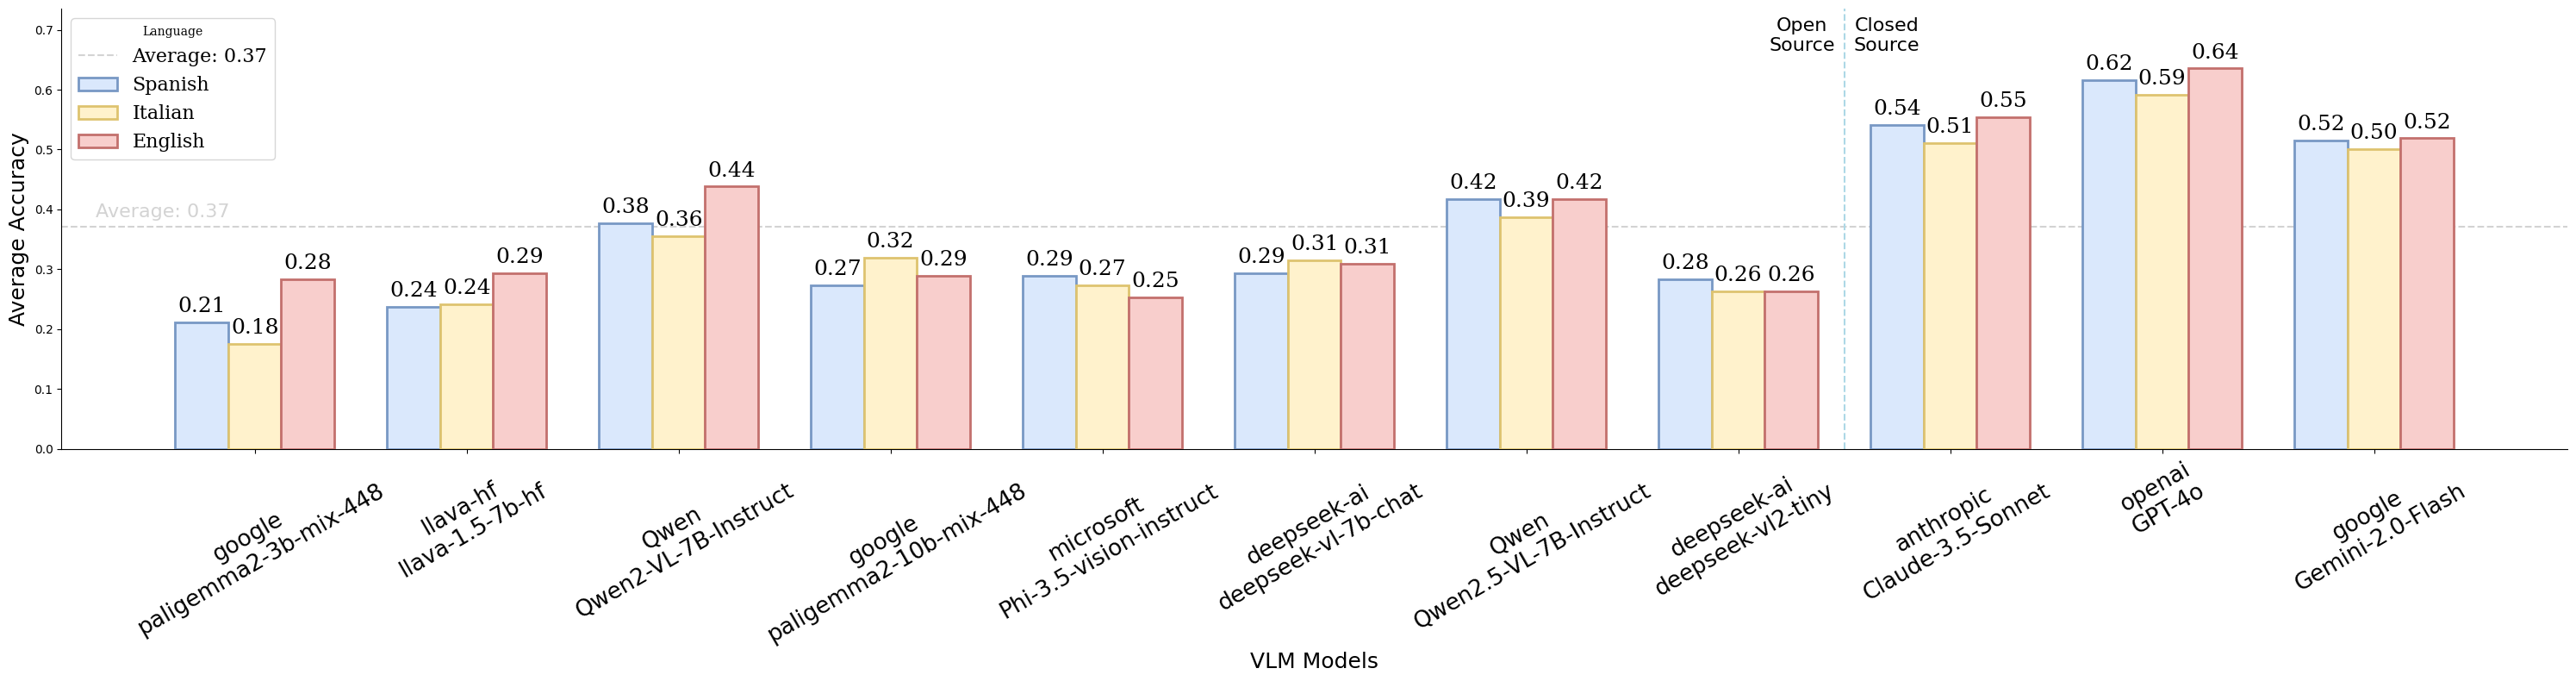

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

# Funzione per aggiungere un vero a capo nei nomi dei modelli
def format_model_name(name):
    parts = name.split("/")  # Split by "/" if necessary
    return "\n".join(parts)  # Convert the string into a more readable format

# Definire i nomi dei modelli (colonne di language_groups)
models = language_groups.columns

# Calcola la media di tutti i modelli e lingue
overall_avg = language_groups.mean().mean()

# Creazione del grafico
fig, ax = plt.subplots(figsize=(30, 8))  # Increased figure size for readability
width = 0.25  # Larghezza delle barre
x = np.arange(len(models))  # Posizioni sull'asse X per i modelli

# Aggiungi la linea orizzontale per la media di tutti i modelli e lingue
ax.axhline(overall_avg, color='lightgray', linestyle='--', linewidth=1.5, label=f'Average: {overall_avg:.2f}')
# Aggiungi il testo sopra la linea tratteggiata
ax.text(-0.5, overall_avg + 0.01, f'Average: {overall_avg:.2f}', color='lightgray', fontsize=16, va='bottom')

# Disegna le barre per ogni lingua con colori distinti
colors = ['#dae8fc', '#fff2cc', '#f8cecc']
for i, lang in enumerate(languages):
  if lang == "English":
    ax.bar(x + i * width, language_groups.loc[lang], width, label=lang, color=colors[i], edgecolor='#c3706d', linewidth=2, zorder=3)
  elif lang == "Italian":
    ax.bar(x + i * width, language_groups.loc[lang], width, label=lang, color=colors[i], edgecolor='#dec36f', linewidth=2, zorder=3)
  else:
    ax.bar(x + i * width, language_groups.loc[lang], width, label=lang, color=colors[i], edgecolor='#7898c4', linewidth=2, zorder=3)


# Aggiungi una linea tratteggiata verticale per separare Open Source e Closed Source
# Troviamo l'indice dove il modello deepseek-vl2-tiny è posizionato (vediamo la posizione X per questa divisione)
separator_index = models.get_loc('deepseek-ai/deepseek-vl2-tiny') + 0.75
ax.axvline(x=separator_index, color='lightblue', linestyle='--', linewidth=1.5)

# Aggiungi le etichette "Open Source" e "Closed Source" accanto alla linea verticale
ax.text(separator_index - 0.2, 0.69, 'Open\nSource', color='black', fontsize=16, ha='center', va='center')
ax.text(separator_index + 0.2, 0.69, 'Closed\nSource', color='black', fontsize=16, ha='center', va='center')

# Impostazioni dei font
plt.rcParams.update({'font.family': 'serif'})  # Setta il font a serif

# Etichette e titoli
ax.set_xlabel("VLM Models", fontsize=18)
ax.set_ylabel("Average Accuracy", fontsize=18)
ax.set_xticks(x + width)
ax.set_xticklabels([format_model_name(m) for m in models], rotation=30, ha="center", fontsize=19)

ax.legend(title="Language", fontsize=16)

# Mostra i valori sopra le barre per maggiore leggibilità
for i, lang in enumerate(languages):
    for j, value in enumerate(language_groups.loc[lang]):
        ax.text(j + i * width, value + 0.01, f'{value:.2f}',
                ha='center', va='bottom', fontsize=18)

# Miglioramenti visivi
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)

# Imposta il limite dell'asse Y per allungarlo un po'
y_max = language_groups.max().max() + 0.10  # Aggiunge un margine del 5% sopra il massimo
ax.set_ylim(0, y_max)

# Salva il grafico come PDF con 500 dpi
plt.tight_layout()
plt.savefig("VLM_Performance_Chart.pdf", format="pdf", dpi=500)

# Mostra il grafico
plt.show()


  Language  Open-Source Mean                                     Open CI  \
0  English          0.318299    (0.2597188509225676, 0.3768788990774324)   
1  Italian          0.291237  (0.23509702270381505, 0.34737747729618496)   
2  Spanish          0.297680    (0.2406607546224563, 0.3546999953775437)   

   Closed-Source Mean                                  Closed CI    t-stat  \
0            0.569159   (0.4204387624152468, 0.7178785709180866) -5.454364   
1            0.533897   (0.4105338536668479, 0.6572608129998188) -5.628538   
2            0.557091  (0.42781708271700986, 0.6863655839496567) -5.898621   

    p-value  
0  0.000403  
1  0.000322  
2  0.000229  
ANOVA F-statistic: 67.6436878540963, p-value: 3.677069399079807e-14


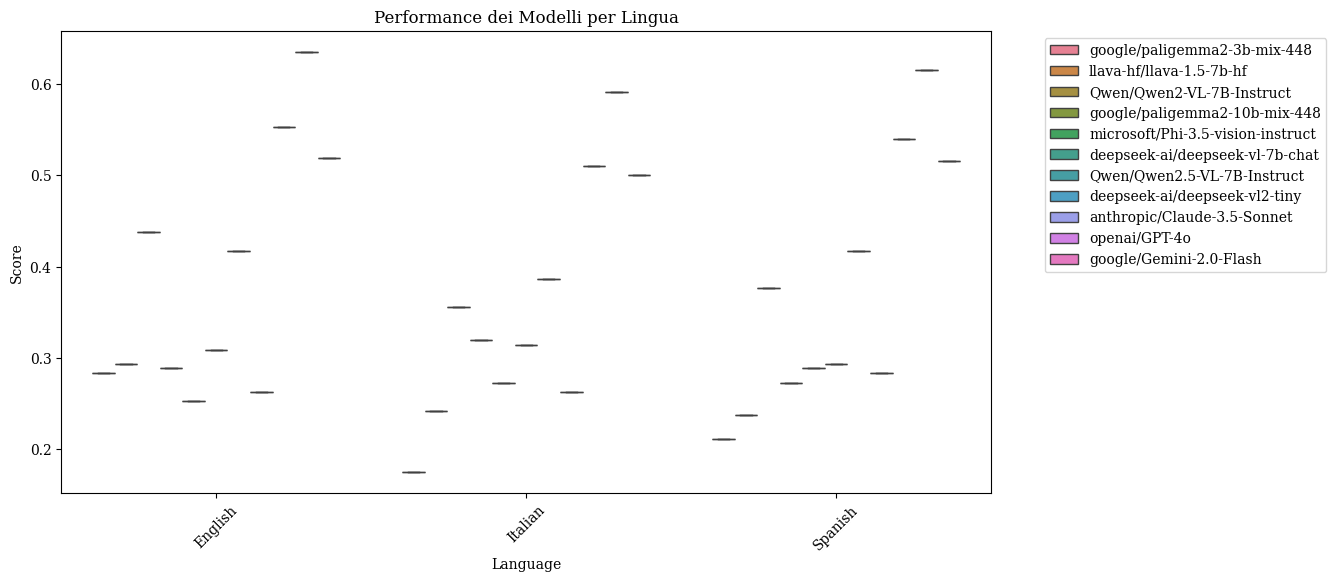

In [ ]:
import pandas as pd
import numpy as np
import scipy.stats as stats
import seaborn as sns
import matplotlib.pyplot as plt

# Caricare il DataFrame (sostituisci con il tuo df2)
df2 = pd.DataFrame({
    "Language": ["English", "Italian", "Spanish"],
    "google/paligemma2-3b-mix-448": [0.283505, 0.175258, 0.211340],
    "llava-hf/llava-1.5-7b-hf": [0.293814, 0.242268, 0.237113],
    "Qwen/Qwen2-VL-7B-Instruct": [0.438144, 0.355670, 0.376289],
    "google/paligemma2-10b-mix-448": [0.288660, 0.319588, 0.273196],
    "microsoft/Phi-3.5-vision-instruct": [0.252577, 0.273196, 0.288660],
    "deepseek-ai/deepseek-vl-7b-chat": [0.309278, 0.314433, 0.293814],
    "Qwen/Qwen2.5-VL-7B-Instruct": [0.417526, 0.386598, 0.417526],
    "deepseek-ai/deepseek-vl2-tiny": [0.262887, 0.262887, 0.283505],
    "anthropic/Claude-3.5-Sonnet": [0.553422, 0.510425, 0.540432],
    "openai/GPT-4o": [0.635323, 0.590943, 0.615421],
    "google/Gemini-2.0-Flash": [0.518731, 0.500324, 0.515421]
})

# Separare i modelli Open-Source e Closed-Source
open_source_models = ["google/paligemma2-3b-mix-448", "llava-hf/llava-1.5-7b-hf",
                      "Qwen/Qwen2-VL-7B-Instruct", "google/paligemma2-10b-mix-448",
                      "microsoft/Phi-3.5-vision-instruct", "deepseek-ai/deepseek-vl-7b-chat",
                      "Qwen/Qwen2.5-VL-7B-Instruct", "deepseek-ai/deepseek-vl2-tiny"]

closed_source_models = ["anthropic/Claude-3.5-Sonnet", "openai/GPT-4o", "google/Gemini-2.0-Flash"]

# Calcolare media e intervallo di confidenza al 95%
def confidence_interval(data):
    mean = np.mean(data)
    sem = stats.sem(data)
    ci = stats.t.interval(0.95, len(data)-1, loc=mean, scale=sem)
    return mean, ci

# Creare un DataFrame con le statistiche
results = []
for lang in df2["Language"]:
    open_vals = df2[df2["Language"] == lang][open_source_models].values.flatten()
    closed_vals = df2[df2["Language"] == lang][closed_source_models].values.flatten()

    open_mean, open_ci = confidence_interval(open_vals)
    closed_mean, closed_ci = confidence_interval(closed_vals)

    t_stat, p_value = stats.ttest_ind(open_vals, closed_vals)

    results.append([lang, open_mean, open_ci, closed_mean, closed_ci, t_stat, p_value])

stats_df = pd.DataFrame(results, columns=["Language", "Open-Source Mean", "Open CI", "Closed-Source Mean", "Closed CI", "t-stat", "p-value"])
print(stats_df)

# ANOVA tra tutti i modelli
data_values = []
for model in df2.columns[1:]:
    for i, lang in enumerate(df2["Language"]):
        data_values.append([lang, model, df2.loc[i, model]])

df_long = pd.DataFrame(data_values, columns=["Language", "Model", "Score"])

anova_result = stats.f_oneway(*[df_long[df_long["Model"] == model]["Score"] for model in df_long["Model"].unique()])
print(f"ANOVA F-statistic: {anova_result.statistic}, p-value: {anova_result.pvalue}")

# Boxplot della distribuzione delle performance
plt.figure(figsize=(12, 6))
sns.boxplot(x="Language", y="Score", hue="Model", data=df_long)
plt.title("Performance dei Modelli per Lingua")
plt.xticks(rotation=45)
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
plt.show()


# ARTEFATTI

## Conversione XLSX in CSV

In [ ]:
# Specifica il nome del file Excel di input e del file di output
input_path = dataset_path + "DataExtractionSpanish_img.xlsx"
output_path = dataset_path + "MIR_Multimodal_Dataset_Spanish.csv"

# Carica il file Excel
initial_df = pd.read_excel(input_path, sheet_name=None)

# Concatena i DataFrame mantenendo le colonne
final_df = pd.concat(initial_df, ignore_index=True)

# Esporta in CSV
final_df.to_csv(output_path, index=False, encoding="utf-8")

print(f"Dati uniti e salvati in {output_path}")

Dati uniti e salvati in /content/drive/MyDrive/Benchmarking LLM/Datasets/Multimodal/MIR_Multimodal_Dataset_Spanish.csv


In [ ]:
final_df

,Category,Question,Image url,AnswerA,AnswerB,AnswerC,AnswerD,AnswerE,Correct Answer
0,Medicina Preventiva,La siguiente figura describe la función de sup...,https://compitoinclasse.org/simulatori/IMGmir/...,La ganancia en términos de mediana de tiempo h...,Para interpretar los resultados de estas dos ...,El ratio de las medianas en el tiempo hasta p...,La prueba de log-rank evalúa la diferencia pr...,Los resultados de la prueba de log-rank y la ...,La ganancia en términos de mediana de tiempo h...
1,Medicina Preventiva,Señale a qué corresponde la imagen:,https://compitoinclasse.org/simulatori/IMGmir/...,Es un gráfico para evaluar el sesgo de publica...,Es un graneo para cuantificar la curtosis de ...,Es un gráfico para cuantificar el error tipo I.,Es un gráfico para evaluar bioequivalencia.,,Es un gráfico para evaluar el sesgo de publica...
2,Medicina Preventiva,De acuerdo a los resultados del ensayo clínico...,https://compitoinclasse.org/simulatori/IMGmir/...,Mirgliptin reduce significativamente la tasa a...,El estudio no es concluyente porque el límite...,Se demuestra la no inferioridad de mirgliptin...,Mirgliptin es no inferior a metformina de acu...,,Mirgliptin es no inferior a metformina de acue...
3,Medicina Preventiva,"Un ensayo clínico, publicado en New England Jo...",https://compitoinclasse.org/simulatori/IMGmir/...,Se observó una frecuencia significativamente m...,No se observaron diferencias significativas e...,La administración de tratamiento puente con h...,Se pudo concluir que el tratamiento con place...,,Se observó una frecuencia significativamente m...
4,Digestivo y C. General,Varón de 75 años con dolor abdominal intermite...,https://compitoinclasse.org/simulatori/IMGmir/...,Tumoración en cola pancreática con calcificaci...,Calcificaciones pancreáticas difusas en cuerp...,Tumoración en cabeza pancreática con calcific...,Calcificaciones pancreáticas difusas en cuerp...,NaN,Calcificaciones pancreáticas difusas en cuerpo...
...,...,...,...,...,...,...,...,...,...
189,Urgencias,"Mujer de 50 años, hipertensa, que acude a urge...",https://compitoinclasse.org/simulatori/IMGmir/...,Disección de aorta,Rotura de aorta,Hematoma intramural de aorta,Úlcera aórtica arteriosclerosa penetrante,,Disección de aorta
190,Urgencias,Es tu primera guardia como médico de emergenci...,https://compitoinclasse.org/simulatori/IMGmir/...,Seguir con el masaje cardiaco y aislar la vía ...,Conseguir un acceso venoso para administrar a...,Cargar el desfibrilador y aplicar una descarg...,Avisar al centro coordinador de emergencias p...,,Cargar el desfibrilador y aplicar una descarga...
191,Urgencias,Paciente de 72 años remitido a urgencias tras ...,https://compitoinclasse.org/simulatori/IMGmir/...,Absceso de psoas izquierdo. Realizaría \nt...,Aneurisma de aorta abdominal roto. Es un...,Completaría el estudio con una ecografía\n...,Tumoración hipervascular del psoas.\nRealiza...,,Aneurisma de aorta abdominal roto. Es una emer...
192,Urgencias,Mujer de 94 años que acude a urgencias por dol...,https://compitoinclasse.org/simulatori/IMGmir/...,Ecografía urgente como test de cribado\ni...,Radiografía de abdomen en bipedestación o \...,TC abdominopélvico con contraste\nintraven...,Arteriografía para descartar oclusión agu...,,TC abdominopélvico con contraste intravenoso c...


In [ ]:
df_types = pd.read_csv(f"{dataset_path}/MIR_Multimodal_Dataset_Spanish.csv")
df_types = df_types['Type']

## Preprocessing dataset

In [ ]:
df = pd.read_csv(f"{dataset_path}MIR_Multimodal_Dataset_Spanish_Prepro.csv")

In [ ]:
df['Category'].unique()

array(['Medicina Preventiva', 'Digestivo y Cirugía General',
       'Infecciosas y Microbiología', 'Cardiología y Cirugía Cardiaca',
       'Neumología y Cirugía Torácica', 'Pediatria',
       'Nefrología y Urología', 'Endocrino y Cirugía Endocrina',
       'Ginecología y Obstetricia', 'Reumatología', 'Hematología',
       'Traumatología', 'Otorrinolaringología', 'Oftalmología',
       'Farmacología', 'Anatomía Patológica', 'Anatomía',
       'Cirugía Vascular', 'Inmunología', 'Genética', 'Oncología',
       'Geriatría', 'Anestesia', 'Urgencias'], dtype=object)

In [ ]:
len(df['Category'].unique())

24

In [ ]:
# Dizionario di mapping delle categorie
category_mapping = {
    'Digestivo y C. General': 'Digestivo y Cirugía General',
    'Cardiología y C. Cardiaca': 'Cardiología y Cirugía Cardiaca',
    'Neumología y C  Torácica': 'Neumología y Cirugía Torácica',
    'Endocrino y c. Endocrina': 'Endocrino y Cirugía Endocrina',
    'C.Vascular': 'Cirugía Vascular'
}

# Applicare la sostituzione al DataFrame
df['Category'] = df['Category'].replace(category_mapping)

# Verificare le nuove categorie
df['Category'].unique()

array(['Medicina Preventiva', 'Digestivo y Cirugía General',
       'Infecciosas y Microbiología', 'Cardiología y Cirugía Cardiaca',
       'Neumología y Cirugía Torácica', 'Pediatria',
       'Nefrología y Urología', 'Endocrino y Cirugía Endocrina',
       'Ginecología y Obstetricia', 'Reumatología', 'Hematología',
       'Traumatología', 'Otorrinolaringología', 'Oftalmología',
       'Farmacología', 'Anatomía Patológica', 'Anatomía',
       'Cirugía Vascular', 'Inmunología', 'Genética', 'Oncología',
       'Geriatría', 'Anestesia', 'Urgencias'], dtype=object)

In [ ]:
df.columns

Index(['Category', 'Question', 'Image url', 'AnswerA', 'AnswerB', 'AnswerC',
       'AnswerD', 'AnswerE', 'Correct Answer', 'Correct Letter'],
      dtype='object')

In [ ]:
# Dizionario per mappare le colonne alle lettere
answer_columns = ['AnswerA', 'AnswerB', 'AnswerC', 'AnswerD', 'AnswerE']
answer_mapping = {col: col[-1] for col in answer_columns}  # {'AnswerA': 'A', 'AnswerB': 'B', ...}

# Funzione per normalizzare il testo (rimuove spazi extra, \n e virgolette)
def clean_text(text):
    if pd.isna(text):  # Controllo per valori NaN
        return ""
    return " ".join(str(text).replace('"', "").split())

# Applicare la pulizia a tutte le colonne di risposte e alla colonna 'Correct Answer'
columns_to_clean = answer_columns + ['Correct Answer']
df[columns_to_clean] = df[columns_to_clean].map(clean_text)

# Funzione per trovare la lettera corrispondente alla risposta corretta
def get_correct_letter(row):
    for col in answer_columns:
        if row['Correct Answer'] == row[col]:  # Ora il confronto è diretto, senza pulizia ripetuta
            return answer_mapping[col]
    return None  # In caso di errore

# Applicare la funzione al DataFrame
df['Correct Letter'] = df.apply(get_correct_letter, axis=1)

# Verificare il risultato
df[['Correct Answer', 'Correct Letter']]

In [ ]:
df.loc[1, 'AnswerB'] = df['AnswerB'][1].replace("graneo", "gráfico")
df

In [ ]:
df = pd.concat([df, df_types], axis=1)

In [ ]:
df

In [ ]:
!python -m spacy download es_core_news_sm

In [ ]:
!pip install -U kaleido

In [ ]:
import pandas as pd
import plotly.express as px

# Raggruppa per "Category" e calcola la percentuale di occorrenze
sunburst_data = df.groupby(['Category']).size().reset_index(name='count')

# Converte i conteggi in percentuali
total_count = sunburst_data['count'].sum()
sunburst_data['percentage'] = (sunburst_data['count'] / total_count) * 100

# Crea il Sunburst Chart usando la percentuale come valore e colore
fig = px.sunburst(
    sunburst_data,
    path=['Category'],
    values='percentage',
    color='percentage',
    color_continuous_scale=["#f8cecc", "#3c9cdd", "#e9445f"]
)

# Trova la percentuale minima e massima
min_freq = sunburst_data['percentage'].min()
max_freq = sunburst_data['percentage'].max()

# Genera una lista di valori per la color bar (0%, 25%, 50%, 75%, 100%)
tickvals = [min_freq,
            min_freq + (max_freq - min_freq) * 0.25,
            min_freq + (max_freq - min_freq) * 0.5,
            min_freq + (max_freq - min_freq) * 0.75,
            max_freq]
ticktext = [f'{v:.1f}%' for v in tickvals]  # Formatta come percentuale
#ticktext = [f"{v:.1f}%".replace("%", " percent") for v in tickvals]

# Layout con la color bar in percentuale
fig.update_layout(
    width=1800,  # Larghezza del grafico
    height=1300,  # Altezza del grafico
    margin=dict(t=50, l=50, r=50, b=50),
    font=dict(size=28),
    paper_bgcolor="white",
    plot_bgcolor="white",
    coloraxis_colorbar=dict(
        x=0.5,
        y=-0.1,
        orientation="h",
        len=0.6,
        title="Percentage",
        tickvals=tickvals,
        ticktext=ticktext,
        title_font=dict(size=30, family='Arial', weight='bold')
    )
)

# Salva il grafico come PDF
fig.write_image("sunburst_chart.pdf")

fig.show()


In [ ]:
conteggi = df['Type'].value_counts()

print(conteggi)

Type
Medical Imaging                   103
Physiological chart and report     39
Histopathological Image            26
Other                              22
Anatomical Illustration             4
Name: count, dtype: int64


In [ ]:
import pandas as pd
import plotly.express as px

# Raggruppa per "Category" e calcola la percentuale di occorrenze
sunburst_data = df.groupby(['Type']).size().reset_index(name='count')

# Converte i conteggi in percentuali
total_count = sunburst_data['count'].sum()
sunburst_data['percentage'] = (sunburst_data['count'] / total_count) * 100

# Crea il Sunburst Chart usando la percentuale come valore e colore
fig = px.sunburst(
    sunburst_data,
    path=['Type'],
    values='percentage',
    color='percentage',
    color_continuous_scale=["#d8dad9", "#3c9cdd", "#e9445f"]
)

# Trova la percentuale minima e massima
min_freq = sunburst_data['percentage'].min()
max_freq = sunburst_data['percentage'].max()

# Genera una lista di valori per la color bar (0%, 25%, 50%, 75%, 100%)
tickvals = [min_freq,
            min_freq + (max_freq - min_freq) * 0.25,
            min_freq + (max_freq - min_freq) * 0.5,
            min_freq + (max_freq - min_freq) * 0.75,
            max_freq]
ticktext = [f'{v:.1f}%' for v in tickvals]  # Formatta come percentuale
#ticktext = [f"{v:.1f}%".replace("%", " percent") for v in tickvals]

# Layout con la color bar in percentuale
fig.update_layout(
    width=800,  # Larghezza del grafico
    height=800,  # Altezza del grafico
    margin=dict(t=50, l=50, r=50, b=50),
    font=dict(size=15),
    paper_bgcolor="white",
    plot_bgcolor="white",
    coloraxis_colorbar=dict(
        x=0.5,
        y=-0.1,
        orientation="h",
        len=0.6,
        title="Percentage",
        tickvals=tickvals,
        ticktext=ticktext,
        title_font=dict(size=30, family='Arial', weight='bold')
    )
)

# Salva il grafico come PDF
fig.write_image("sunburst_chart_types.pdf")

fig.show()


In [ ]:
prepro_path = dataset_path+"MIR_Multimodal_Dataset_Spanish_Prepro.csv"

# Esporta in CSV
df.to_csv(prepro_path, index=False, encoding="utf-8")

print(f"Dati puliti e salvati in {prepro_path}")

Dati puliti e salvati in /content/drive/MyDrive/Benchmarking LLM/Datasets/Multimodal/MIR_Multimodal_Dataset_Spanish_Prepro.csv


## Generazione Dataset in Inglese e Italiano

In [ ]:
!pip install deep_translator

In [ ]:
df = pd.read_csv(f"{dataset_path}MIR_Multimodal_Dataset_Spanish_Prepro.csv")

### Traduzione Spagnolo -> Inglese

In [ ]:
from deep_translator import GoogleTranslator

# Specifica il nome del file di output
english_path = dataset_path + "MIR_Multimodal_Dataset_English.csv"

# Crea un traduttore
translator = GoogleTranslator(source='es', target='en')

# Trova le colonne da tradurre (tutte tranne 'Image url')
columns_to_translate = [col for col in df.columns if col.lower() != 'image url']

english_df = df.copy()
# Traduci evitando duplicati
for col in columns_to_translate:
    print(f"Traducendo la colonna: {col}\n")
    unique_values = english_df[col].dropna().unique()  # Evita di tradurre i NaN
    translated_values = {val: translator.translate(val) for val in unique_values}
    english_df[col] = english_df[col].map(translated_values)

# Esporta in CSV
english_df.to_csv(english_path, index=False, encoding="utf-8")

print(f"Dati tradotti in inglese salvati in {english_path}")

Traducendo la colonna: Category

Traducendo la colonna: Question

Traducendo la colonna: AnswerA

Traducendo la colonna: AnswerB

Traducendo la colonna: AnswerC

Traducendo la colonna: AnswerD

Traducendo la colonna: AnswerE

Traducendo la colonna: Correct Answer

Traducendo la colonna: Correct Letter

Dati tradotti in inglese salvati in /content/drive/MyDrive/Benchmarking LLM/Datasets/Multimodal/MIR_Multimodal_Dataset_English.csv


In [ ]:
english_df

In [ ]:
english_df['Question'][0]

'The following figure describes the survival function of the disease-free progression variable (Progression-Free Survival, PFS) by means of the Kaplanmeier method of two groups of patients. Group A: Patients treated with the best support treatment (Best Suportive Care, BSC). Group B: Patients who in addition to BSC receive Panitumumab. Complementary data to the figure: Patients with disease progression: Group A = 184/232 (79%), Group B = 161/231 (70%). Percentage of censures: Group A = 24/232 (10%), Group B = 38/231 (16%). Log-Rank test P <0.0001. Hazard Ratio 95% C1: 0.54 [0.44-0.66]. Which of the following statements is correct:'

In [ ]:
df['Question'][0]

'La siguiente figura describe la función de supervivencia de la variable progresión libre de enfermedad (Progression-free Survival, PFS) mediante el método de KaplanMeier de dos grupos de pacientes. Grupo A: pacientes tratados con el mejor tratamiento de soporte (Best Suportive Care, BSC). Grupo B: pacientes que además de BSC reciben Panitumumab. Datos complementarios a la figura: pacientes con progresión de enfermedad: Grupo A=184/232 (79%), Grupo B=161/231 (70%). Porcentaje de censuras: Grupo A=24/232 (10%), Grupo B=38/231(16%). Prueba de log-rank p<0.0001. Hazard Ratio 95% C1: 0.54 [0.44-0.66]. Cuál de las siguientes afirmaciones es correcta:'

### Traduzione Spagnolo -> Italiano

In [ ]:
from deep_translator import GoogleTranslator

# Specifica il nome del file di output
italian_path = dataset_path + "MIR_Multimodal_Dataset_Italian.csv"

# Crea un traduttore
translator = GoogleTranslator(source='es', target='it')

# Trova le colonne da tradurre (tutte tranne 'Image url')
columns_to_translate = [col for col in df.columns if col.lower() != 'image url']

italian_df = df.copy()
# Traduci evitando duplicati
for col in columns_to_translate:
    print(f"Traducendo la colonna: {col}\n")
    unique_values = italian_df[col].dropna().unique()  # Evita di tradurre i NaN
    translated_values = {val: translator.translate(val) for val in unique_values}
    italian_df[col] = italian_df[col].map(translated_values)

# Esporta in CSV
italian_df.to_csv(italian_path, index=False, encoding="utf-8")

print(f"Dati tradotti in italiano salvati in {italian_path}")

Traducendo la colonna: Category

Traducendo la colonna: Question

Traducendo la colonna: AnswerA

Traducendo la colonna: AnswerB

Traducendo la colonna: AnswerC

Traducendo la colonna: AnswerD

Traducendo la colonna: AnswerE

Traducendo la colonna: Correct Answer

Traducendo la colonna: Correct Letter

Dati tradotti in italiano salvati in /content/drive/MyDrive/Benchmarking LLM/Datasets/Multimodal/MIR_Multimodal_Dataset_Italian.csv


In [ ]:
italian_df

In [ ]:
italian_df['Question'][0]

'La figura seguente descrive la funzione di sopravvivenza della variabile di progressione priva di malattie (sopravvivenza libera da progressione, PFS) per mezzo del metodo Kaplanmeier di due gruppi di pazienti. Gruppo A: pazienti trattati con il miglior trattamento di supporto (miglior cure sovraportive, BSC). Gruppo B: pazienti che oltre a BSC ricevono panitumumab. Dati complementari alla figura: pazienti con progressione della malattia: gruppo A = 184/232 (79%), gruppo B = 161/231 (70%). Percentuale di censure: gruppo A = 24/232 (10%), gruppo B = 38/231 (16%). Test log-rank p <0,0001. HABARD RAPORO 95% C1: 0,54 [0,44-0,66]. Quale delle seguenti affermazioni è corretta:'

In [ ]:
df['Question'][0]

'La siguiente figura describe la función de supervivencia de la variable progresión libre de enfermedad (Progression-free Survival, PFS) mediante el método de KaplanMeier de dos grupos de pacientes. Grupo A: pacientes tratados con el mejor tratamiento de soporte (Best Suportive Care, BSC). Grupo B: pacientes que además de BSC reciben Panitumumab. Datos complementarios a la figura: pacientes con progresión de enfermedad: Grupo A=184/232 (79%), Grupo B=161/231 (70%). Porcentaje de censuras: Grupo A=24/232 (10%), Grupo B=38/231(16%). Prueba de log-rank p<0.0001. Hazard Ratio 95% C1: 0.54 [0.44-0.66]. Cuál de las siguientes afirmaciones es correcta:'

## Analisi sulle traduzioni

In [ ]:
ita_path = dataset_path + "MIR_Multimodal_Dataset_Italian.csv"

ita_df = pd.read_csv(ita_path)

In [ ]:
from deep_translator import GoogleTranslator

translator = GoogleTranslator(source='en', target='it')
processed_text = ita_df['Question'][4].replace(" -", "-")
print(processed_text)

text = translator.translate(processed_text)

75-year-old maschio con dolore addominale intermittente, dispepsia e perdita di peso. Il TC addominale viene eseguito con il contrasto di cui viene mostrata un'immagine. Oltre all'osservazione casuale di una cisti renale sinistra, quale dei seguenti risultati è?:


In [ ]:
df = pd.read_csv("/content/drive/MyDrive/Benchmarking LLM/Datasets/Multimodal/MIR_Multimodal_Dataset_Spanish_Prepro.csv")

In [ ]:
import pandas as pd
import spacy
from collections import Counter
from tqdm.auto import tqdm

# Carica il modello spagnolo (per l'italiano potresti usare "it_core_news_sm")
nlp = spacy.load("es_core_news_sm", disable=["parser", "ner"])

# Funzione per tokenizzare in batch (utile per grandi quantità di testo)
def tokenize_texts(texts):
    tokens = []
    for doc in nlp.pipe(texts, batch_size=500):
        tokens.extend([token.text.lower() for token in doc if not token.is_punct and not token.is_space])
    return tokens

# Funzione per contare i token in un singolo testo
def count_tokens(text):
    doc = nlp(str(text))
    return len([token for token in doc if not token.is_punct and not token.is_space])

# -------------------------
# Tokenizzazione batch per le domande
question_texts = df["Question"].tolist()
print("Tokenizzazione batch delle domande...")
tokens = tokenize_texts(tqdm(question_texts, desc="Tokenizzazione domande"))
token_counts = Counter(tokens)

print(f"Totale token Question (batch): {sum(token_counts.values())}")
print(f"Vocabolario unico Question (batch): {len(token_counts)}")

# -------------------------
# Calcolo lunghezza token per ogni domanda e opzione

print("\nCalcolo lunghezza token per domande e opzioni...")
# Calcola la lunghezza (in token) per le domande
df['question_len'] = df['Question'].apply(count_tokens)

# Definisci le colonne delle opzioni (modifica se i nomi sono diversi)
option_cols = ['AnswerA', 'AnswerB', 'AnswerC', 'AnswerD', 'AnswerE']

# Applica la funzione di tokenizzazione per ogni opzione (ignorando eventuali valori mancanti)
for col in option_cols:
    if col in df.columns:
        df[col + '_len'] = df[col].dropna().apply(count_tokens)

# -------------------------
# Calcolo delle statistiche per le domande
avg_question_len = df['question_len'].mean()
max_question_len = df['question_len'].max()

# Aggrega le lunghezze di tutte le opzioni in una lista
option_lengths = []
for col in option_cols:
    if col + '_len' in df.columns:
        option_lengths.extend(df[col + '_len'].dropna().tolist())

if option_lengths:
    avg_option_len = sum(option_lengths) / len(option_lengths)
    max_option_len = max(option_lengths)
    total_option_tokens = sum(option_lengths)
else:
    avg_option_len = 0
    max_option_len = 0
    total_option_tokens = 0

# -------------------------
# Output finale delle statistiche token
print("\nStatistiche token:")
print("Avg. option len:", avg_option_len)
print("Max. option len:", max_option_len)
print("Totale token Option:", total_option_tokens)
print("Avg. question len:", avg_question_len)
print("Max. question len:", max_question_len)


Tokenizzazione batch delle domande...


Tokenizzazione domande:   0%|          | 0/194 [00:00<?, ?it/s]

Totale token Question (batch): 10898
Vocabolario unico Question (batch): 2495

Calcolo lunghezza token per domande e opzioni...

Statistiche token:
Avg. option len: 6.849514563106796
Max. option len: 41
Totale token Option: 5644.0
Avg. question len: 56.175257731958766
Max. question len: 223


In [ ]:
df = pd.read_csv("/content/drive/MyDrive/Benchmarking LLM/Datasets/Multimodal/MIR_Multimodal_Dataset_English_Prepro.csv")

In [ ]:
!python -m spacy download en_core_web_sm

In [ ]:
import pandas as pd
import spacy
from collections import Counter
from tqdm.auto import tqdm

# Carica il modello spagnolo (per l'italiano potresti usare "it_core_news_sm")
nlp = spacy.load("en_core_web_sm", disable=["parser", "ner"])

# Funzione per tokenizzare in batch (utile per grandi quantità di testo)
def tokenize_texts(texts):
    tokens = []
    for doc in nlp.pipe(texts, batch_size=500):
        tokens.extend([token.text.lower() for token in doc if not token.is_punct and not token.is_space])
    return tokens

# Funzione per contare i token in un singolo testo
def count_tokens(text):
    doc = nlp(str(text))
    return len([token for token in doc if not token.is_punct and not token.is_space])

# -------------------------
# Tokenizzazione batch per le domande
question_texts = df["Question"].tolist()
print("Tokenizzazione batch delle domande...")
tokens = tokenize_texts(tqdm(question_texts, desc="Tokenizzazione domande"))
token_counts = Counter(tokens)

print(f"Totale token Question (batch): {sum(token_counts.values())}")
print(f"Vocabolario unico Question (batch): {len(token_counts)}")

# -------------------------
# Calcolo lunghezza token per ogni domanda e opzione

print("\nCalcolo lunghezza token per domande e opzioni...")
# Calcola la lunghezza (in token) per le domande
df['question_len'] = df['Question'].apply(count_tokens)

# Definisci le colonne delle opzioni (modifica se i nomi sono diversi)
option_cols = ['AnswerA', 'AnswerB', 'AnswerC', 'AnswerD', 'AnswerE']

# Applica la funzione di tokenizzazione per ogni opzione (ignorando eventuali valori mancanti)
for col in option_cols:
    if col in df.columns:
        df[col + '_len'] = df[col].dropna().apply(count_tokens)

# -------------------------
# Calcolo delle statistiche per le domande
avg_question_len = df['question_len'].mean()
max_question_len = df['question_len'].max()

# Aggrega le lunghezze di tutte le opzioni in una lista
option_lengths = []
for col in option_cols:
    if col + '_len' in df.columns:
        option_lengths.extend(df[col + '_len'].dropna().tolist())

if option_lengths:
    avg_option_len = sum(option_lengths) / len(option_lengths)
    max_option_len = max(option_lengths)
    total_option_tokens = sum(option_lengths)
else:
    avg_option_len = 0
    max_option_len = 0
    total_option_tokens = 0

# -------------------------
# Output finale delle statistiche token
print("\nStatistiche token:")
print("Avg. option len:", avg_option_len)
print("Max. option len:", max_option_len)
print("Totale token Option:", total_option_tokens)
print("Avg. question len:", avg_question_len)
print("Max. question len:", max_question_len)


Tokenizzazione batch delle domande...


Tokenizzazione domande:   0%|          | 0/194 [00:00<?, ?it/s]

Totale token Question (batch): 10213
Vocabolario unico Question (batch): 2606

Calcolo lunghezza token per domande e opzioni...

Statistiche token:
Avg. option len: 6.574029126213592
Max. option len: 39
Totale token Option: 5417.0
Avg. question len: 52.644329896907216
Max. question len: 190


In [ ]:
df = pd.read_csv("/content/drive/MyDrive/Benchmarking LLM/Datasets/Multimodal/MIR_Multimodal_Dataset_Italian.csv")

In [ ]:
!python -m spacy download it_core_news_sm

In [ ]:
import pandas as pd
import spacy
from collections import Counter
from tqdm.auto import tqdm

# Carica il modello spagnolo (per l'italiano potresti usare "it_core_news_sm")
nlp = spacy.load("it_core_news_sm", disable=["parser", "ner"])

# Funzione per tokenizzare in batch (utile per grandi quantità di testo)
def tokenize_texts(texts):
    tokens = []
    for doc in nlp.pipe(texts, batch_size=500):
        tokens.extend([token.text.lower() for token in doc if not token.is_punct and not token.is_space])
    return tokens

# Funzione per contare i token in un singolo testo
def count_tokens(text):
    doc = nlp(str(text))
    return len([token for token in doc if not token.is_punct and not token.is_space])

# -------------------------
# Tokenizzazione batch per le domande
question_texts = df["Question"].tolist()
print("Tokenizzazione batch delle domande...")
tokens = tokenize_texts(tqdm(question_texts, desc="Tokenizzazione domande"))
token_counts = Counter(tokens)

print(f"Totale token Question (batch): {sum(token_counts.values())}")
print(f"Vocabolario unico Question (batch): {len(token_counts)}")

# -------------------------
# Calcolo lunghezza token per ogni domanda e opzione

print("\nCalcolo lunghezza token per domande e opzioni...")
# Calcola la lunghezza (in token) per le domande
df['question_len'] = df['Question'].apply(count_tokens)

# Definisci le colonne delle opzioni (modifica se i nomi sono diversi)
option_cols = ['AnswerA', 'AnswerB', 'AnswerC', 'AnswerD', 'AnswerE']

# Applica la funzione di tokenizzazione per ogni opzione (ignorando eventuali valori mancanti)
for col in option_cols:
    if col in df.columns:
        df[col + '_len'] = df[col].dropna().apply(count_tokens)

# -------------------------
# Calcolo delle statistiche per le domande
avg_question_len = df['question_len'].mean()
max_question_len = df['question_len'].max()

# Aggrega le lunghezze di tutte le opzioni in una lista
option_lengths = []
for col in option_cols:
    if col + '_len' in df.columns:
        option_lengths.extend(df[col + '_len'].dropna().tolist())

if option_lengths:
    avg_option_len = sum(option_lengths) / len(option_lengths)
    max_option_len = max(option_lengths)
    total_option_tokens = sum(option_lengths)
else:
    avg_option_len = 0
    max_option_len = 0
    total_option_tokens = 0

# -------------------------
# Output finale delle statistiche token
print("\nStatistiche token:")
print("Avg. option len:", avg_option_len)
print("Max. option len:", max_option_len)
print("Totale token Option:", total_option_tokens)
print("Avg. question len:", avg_question_len)
print("Max. question len:", max_question_len)


Tokenizzazione batch delle domande...


Tokenizzazione domande:   0%|          | 0/194 [00:00<?, ?it/s]

Totale token Question (batch): 10545
Vocabolario unico Question (batch): 2519

Calcolo lunghezza token per domande e opzioni...

Statistiche token:
Avg. option len: 6.70873786407767
Max. option len: 39
Totale token Option: 5528.0
Avg. question len: 54.355670103092784
Max. question len: 197
